# Home Credit Default Risk

We have a dataframe in which are registered a lot of information about a bank's clients.

The bank wants to know if they should give them a loan or not. The machine learning model needs to predict if the client will repay the loan or not.

If the target is equal to 0: the loan was repaid, if it's equal to 1: the loan was not repaid.

The models will determine if the loan will be repaid or not according to the given features.

# Summary

* Data observation
* Data cleanup
* Feature Selection with Boruta 

Machine Learning Models: 
* KNeighbors Classifier using Grid Search
* Logistic Regression
* Decision Tree
* Random Forest
* XGBoost

* Comparing models predictions on application test

# Library used

In [208]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import graphviz

# Undersampling
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Machine Learning Library
from sklearn import metrics
from sklearn.metrics import multilabel_confusion_matrix, classification_report, accuracy_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
import joblib

# Grid Search
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Boruta
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy as bp
from sklearn.datasets import load_boston

# KNeighbors Classifier
from sklearn.neighbors import KNeighborsClassifier

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Decision Tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# XGBoost
import xgboost as xgb

from warnings import filterwarnings
filterwarnings('ignore')

# Data

In [243]:
app_train = pd.read_csv("./resources/application_train.csv", encoding='utf-8', sep=',')
app_test = pd.read_csv("./resources/application_test.csv", encoding='utf-8', sep=',')
app_train.drop_duplicates()
app_test.drop_duplicates()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


## Aligning the two datasets

In [210]:
train_labels = app_train['TARGET']
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)
app_train['TARGET'] = train_labels
print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 122)
Testing Features shape:  (48744, 121)


# Data Analysis before Cleanup

In [211]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

## Is data unbalanced ? 

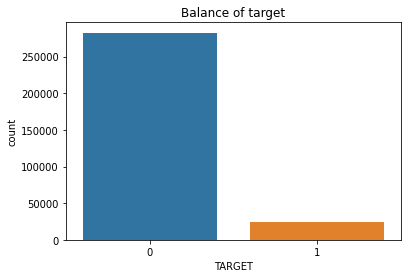

Unbalanced data on the TARGET column:
0    282686
1     24825
Name: TARGET, dtype: int64


In [212]:
fig = sns.countplot(x="TARGET", data=app_train)
plt.title('Balance of target')
plt.show()
print("Unbalanced data on the TARGET column:")
print(app_train['TARGET'].value_counts())

The data is very unbalanced.

## Education Type

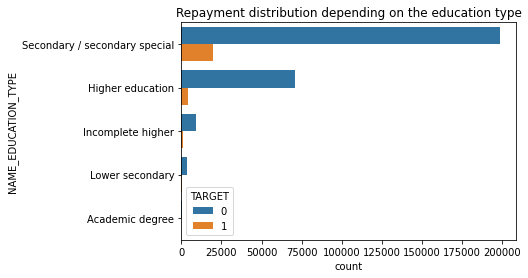

In [254]:
fig = sns.countplot(y="NAME_EDUCATION_TYPE", hue="TARGET", data=app_train)
plt.title('Repayment distribution depending on the education type')
plt.show()

## Client's work

### Occupation Type

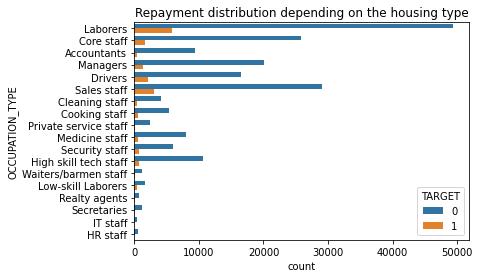

In [213]:
fig = sns.countplot(y="OCCUPATION_TYPE", hue="TARGET", data=app_train)
plt.title('Repayment distribution depending on the housing type')
plt.show()

## Housing Type

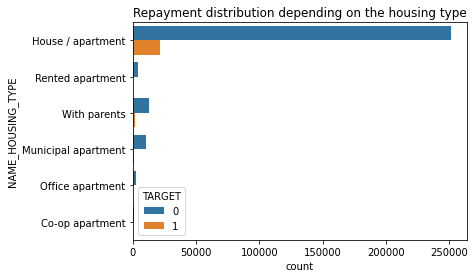

In [214]:
fig = sns.countplot(y="NAME_HOUSING_TYPE", hue="TARGET", data=app_train)
plt.title('Repayment distribution depending on the housing type')
plt.show()

## Number of Children

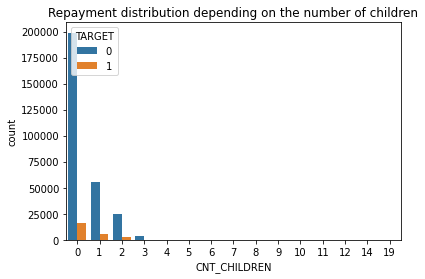

In [215]:
fig = sns.countplot(x="CNT_CHILDREN", hue="TARGET" , data=app_train)
plt.title('Repayment distribution depending on the number of children')
plt.show()

## Family Status

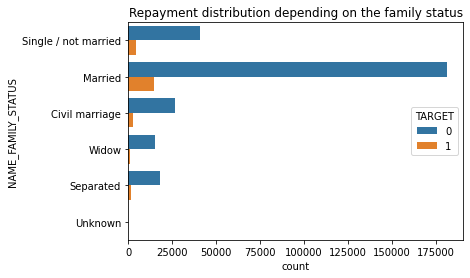

In [216]:
fig = sns.countplot(y="NAME_FAMILY_STATUS", hue="TARGET" , data=app_train)
plt.title('Repayment distribution depending on the family status')
plt.show()

## Gender distribution

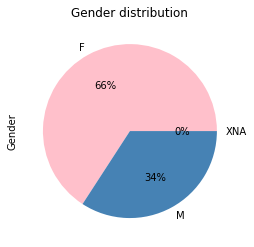

In [217]:
gender_group = app_train.groupby(['CODE_GENDER'])
gender_group.size().plot(kind='pie', 
                         ylabel='Gender', 
                         colors=['pink', 'steelblue', 'pink'], 
                         title='Gender distribution',
                         autopct='%.0f%%')
plt.show()

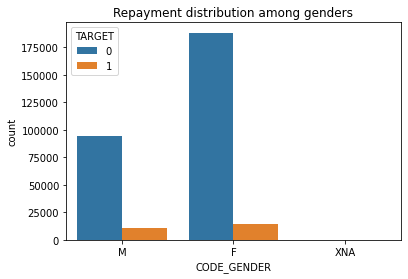

In [218]:
fig = sns.countplot(x="CODE_GENDER", hue="TARGET" , data=app_train)
plt.title('Repayment distribution among genders')
plt.show()

### Contract type distribution

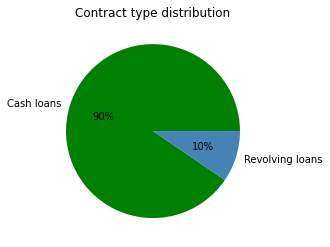

In [219]:
contract_group = app_train.groupby(['NAME_CONTRACT_TYPE'])
contract_group.size().plot(kind='pie', 
                           ylabel='', 
                           colors=['green', 'steelblue'], 
                           title='Contract type distribution',
                           autopct='%.0f%%')
plt.show()

## Age / Days Birth

In [262]:
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])

### Distribution of age among clients

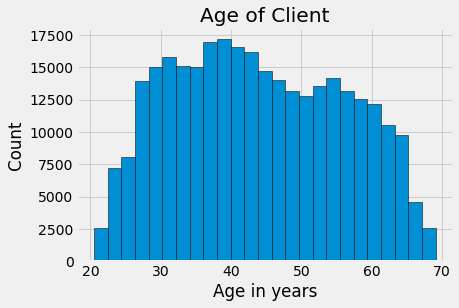

In [263]:
# Set the style of plots
plt.style.use('fivethirtyeight')
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age in years'); plt.ylabel('Count');

### Distribution of Target depending on the age

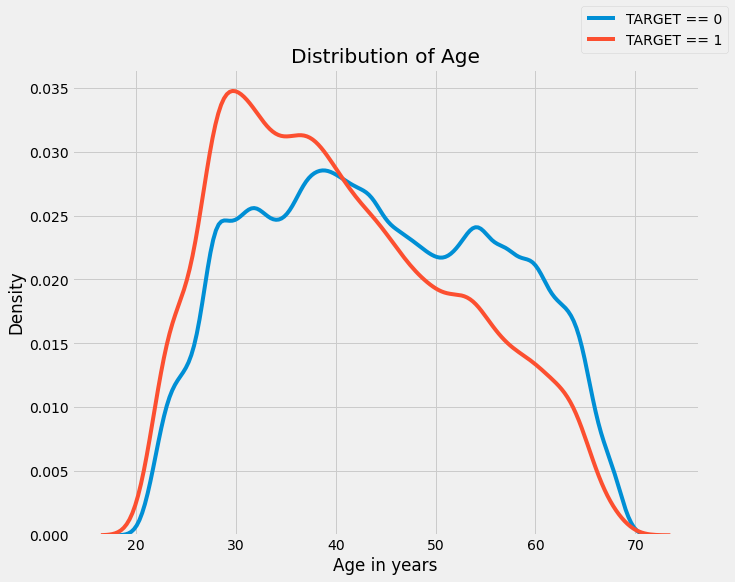

In [264]:
fig = plt.figure(figsize = (10, 8))
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'TARGET == 0')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'TARGET == 1')
fig.legend(labels=['TARGET == 0', 'TARGET == 1'])
plt.xlabel('Age in years'); plt.ylabel('Density'); plt.title('Distribution of Age');

### Informations

In [220]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

### Minimum and maximum value

In [221]:
mini = abs(app_train['DAYS_BIRTH'].max())
if mini > 365:
    print("Days birth min :", mini/365, "days" )
else:
    print("Days birth min :", mini, "days" )
    
maxi = abs(app_train['DAYS_BIRTH'].min())
print("Days birth max :", maxi/365, "years" )

Days birth min : 20.517808219178082 days
Days birth max : 69.12054794520547 years


### Boxplots

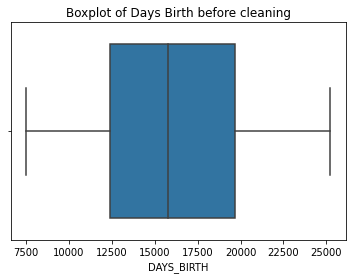

In [222]:
ax = sns.boxplot(x=abs(app_train['DAYS_BIRTH']))
plt.title('Boxplot of Days Birth before cleaning')
plt.show()

## Missing values

In [223]:
print("30 first columns filled with the most NaN values with their percentage:")
((app_train.isnull().sum()/app_train.shape[0])*100).sort_values(ascending=False).head(30)

30 first columns filled with the most NaN values with their percentage:


COMMONAREA_MODE             69.872297
COMMONAREA_AVG              69.872297
COMMONAREA_MEDI             69.872297
NONLIVINGAPARTMENTS_MEDI    69.432963
NONLIVINGAPARTMENTS_AVG     69.432963
NONLIVINGAPARTMENTS_MODE    69.432963
FONDKAPREMONT_MODE          68.386172
LIVINGAPARTMENTS_MEDI       68.354953
LIVINGAPARTMENTS_AVG        68.354953
LIVINGAPARTMENTS_MODE       68.354953
FLOORSMIN_MEDI              67.848630
FLOORSMIN_AVG               67.848630
FLOORSMIN_MODE              67.848630
YEARS_BUILD_AVG             66.497784
YEARS_BUILD_MEDI            66.497784
YEARS_BUILD_MODE            66.497784
OWN_CAR_AGE                 65.990810
LANDAREA_AVG                59.376738
LANDAREA_MODE               59.376738
LANDAREA_MEDI               59.376738
BASEMENTAREA_MODE           58.515956
BASEMENTAREA_MEDI           58.515956
BASEMENTAREA_AVG            58.515956
EXT_SOURCE_1                56.381073
NONLIVINGAREA_AVG           55.179164
NONLIVINGAREA_MODE          55.179164
NONLIVINGARE

## Correlations

In [224]:
correlations = app_train.corr()['TARGET'].sort_values()
print('Most Positive Correlations:\n')
print(correlations.tail(15))
print('\nMost Negative Correlations:\n')
print(correlations.head(15))

Most Positive Correlations:

DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:

EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645


# Data cleanup 

In [225]:
# Graph Data
graph_data = app_train.copy()
graph_data.replace([np.inf, -np.inf], np.nan, inplace=True)
X = graph_data
Y = np.array(graph_data['TARGET'])
X.drop('TARGET', axis=1, inplace=True)
rus = RandomUnderSampler(random_state=0)
graph_data, y_resampled = rus.fit_resample(X,Y)
graph_data['TARGET'] = y_resampled
imputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent").fit(graph_data)
imputer = imputer.fit_transform(graph_data)
graph_data = pd.DataFrame(imputer, columns = app_train.columns.values.tolist())
graph_data.drop(graph_data.index[(graph_data["DAYS_EMPLOYED"] > 12000)], axis=0, inplace=True)

## Label Encoding

In [226]:
le = LabelEncoder()
le_count = 0

for col in app_train:
    if app_train[col].dtype == 'object' or app_train[col].dtype == 'string':
        le.fit(app_train[col])
        app_train[col] = le.transform(app_train[col])
        app_test[col] = le.transform(app_test[col])
        le_count += 1
        print(col)
app_train.reset_index()
app_test.reset_index()
print('%d columns were label encoded.' % le_count)

NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
OCCUPATION_TYPE
WEEKDAY_APPR_PROCESS_START
ORGANIZATION_TYPE
FONDKAPREMONT_MODE
HOUSETYPE_MODE
WALLSMATERIAL_MODE
EMERGENCYSTATE_MODE
16 columns were label encoded.


## Infinite values

In [227]:
# Replacing Infinite values with NaN values
app_train.replace([np.inf, -np.inf], np.nan, inplace=True)
app_test.replace([np.inf, -np.inf], np.nan, inplace=True)

## Missing values

In [228]:
# app_train
imputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent").fit(app_train)
imputer = imputer.fit_transform(app_train)
app_train = pd.DataFrame(imputer, columns = app_train.columns.values.tolist())
# app_test
imputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent").fit(app_test)
imputer = imputer.fit_transform(app_test)
app_test = pd.DataFrame(imputer, columns = app_test.columns.values.tolist())

## Handling unbalanced data

In [229]:
# Undersampling
X = app_train
Y = np.array(app_train['TARGET'])
X.drop('TARGET', axis=1, inplace=True)

rus = RandomUnderSampler(random_state=0)
app_train, y_resampled = rus.fit_resample(X,Y)
app_train['TARGET'] = y_resampled
print(sorted(Counter(y_resampled).items()), y_resampled.shape)

[(0.0, 24825), (1.0, 24825)] (49650,)


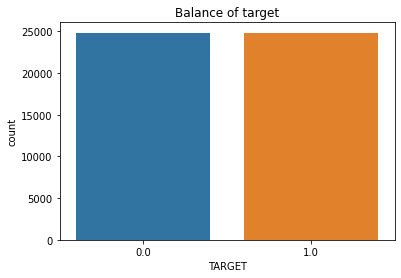

In [230]:
fig = sns.countplot(x="TARGET", data=app_train)
plt.title('Balance of target')
plt.show()

The target column is now balanced, this will allow the models to get better results.

## Days Employed feature

### Informations 

In [231]:
app_train['DAYS_EMPLOYED'].describe()

count     49650.000000
mean      54464.751078
std      132619.746910
min      -16836.000000
25%       -2479.750000
50%       -1115.000000
75%        -331.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

### Minimum and maximum values

In [232]:
mini = abs(app_train['DAYS_EMPLOYED'].max())
if mini > 365:
    print("Days employed min :", mini/365, "years" )
else:
    print("Days employed min :", mini, "days" )
    
maxi = abs(app_train['DAYS_EMPLOYED'].min())
print("Days employed max :", maxi/365, "years" )

Days employed min : 1000.6657534246575 years
Days employed max : 46.12602739726027 years


We can see an anomaly : the biggest 'Days Employed' value is around 1000 years !

### Boxplots

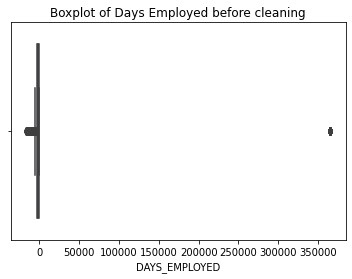

In [233]:
ax = sns.boxplot(x=app_train['DAYS_EMPLOYED'])
plt.title('Boxplot of Days Employed before cleaning')
plt.show()

### Removing anomalies

In [234]:
app_train.drop(app_train.index[(app_train["DAYS_EMPLOYED"] > 12000)], axis=0, inplace=True)
app_test.drop(app_test.index[(app_test["DAYS_EMPLOYED"] > 12000)], axis=0, inplace=True)

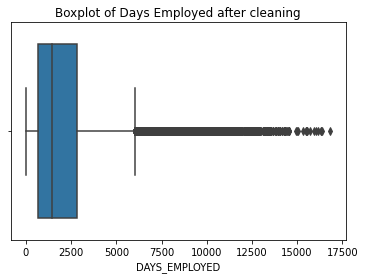

In [235]:
ax = sns.boxplot(x=abs(app_train['DAYS_EMPLOYED']))
plt.title('Boxplot of Days Employed after cleaning')
plt.show()

# Data Analysis after Cleanup

We will see in this section that if we don't clean and balance our data, we can get the wrong picture and base our work on the wrong analysis.

## Education Type

In [ ]:
fig = sns.countplot(y="NAME_EDUCATION_TYPE", hue="TARGET", data=graph_data)
plt.title('Repayment distribution depending on the education type')
plt.show()

## Client's work

### Occupation Type

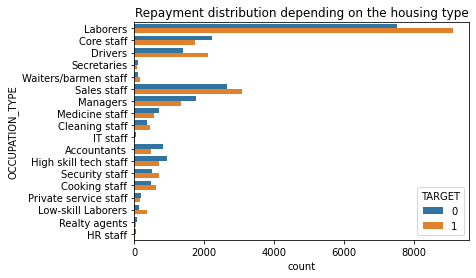

In [241]:
fig = sns.countplot(y="OCCUPATION_TYPE", hue="TARGET", data=graph_data)
plt.title('Repayment distribution depending on the housing type')
plt.show()

## Housing Type

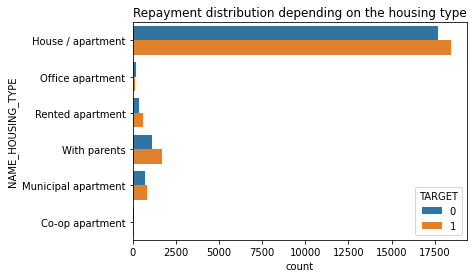

In [236]:
fig = sns.countplot(y="NAME_HOUSING_TYPE", hue="TARGET", data=graph_data)
plt.title('Repayment distribution depending on the housing type')
plt.show()

## Number of Children

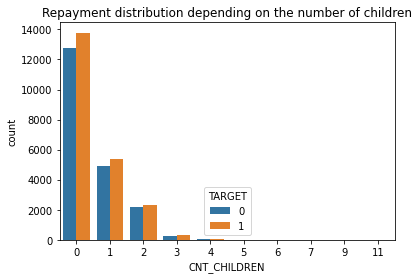

In [237]:
fig = sns.countplot(x="CNT_CHILDREN", hue="TARGET" , data=graph_data)
plt.title('Repayment distribution depending on the number of children')
plt.show()

## Family Status

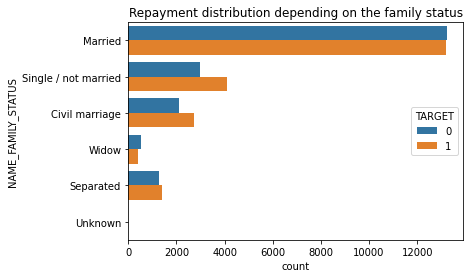

In [238]:
fig = sns.countplot(y="NAME_FAMILY_STATUS", hue="TARGET" , data=graph_data)
plt.title('Repayment distribution depending on the family status')
plt.show()

## Gender Feature

After labelEncoding, we have : Female == 0.0 and Male == 1.0

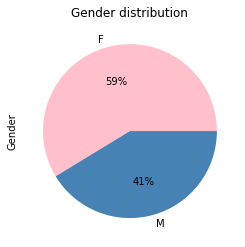

In [239]:
gender_group = graph_data.groupby(['CODE_GENDER'])
gender_group.size().plot(kind='pie', 
                         ylabel='Gender', 
                         colors=['pink', 'steelblue', 'pink'], 
                         title='Gender distribution',
                         autopct='%.0f%%')
plt.show()

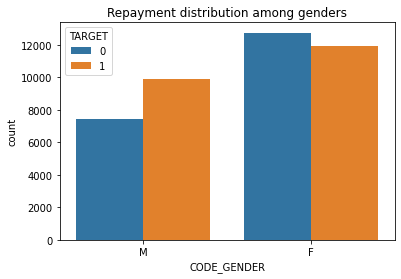

In [240]:
fig = sns.countplot(x="CODE_GENDER", hue="TARGET" , data=graph_data)
    
plt.title('Repayment distribution among genders')
plt.show()

# Boruta

In [27]:
Xdf = app_train.copy()
Xdf.drop('TARGET', axis = 1, inplace = True)
X_boruta = Xdf

y = app_train["TARGET"]

In [28]:
forest = RandomForestRegressor(
    n_jobs=-1,
    max_depth=5
)

boruta = bp(
    estimator=forest,
    n_estimators=20,
    max_iter=100 # numbers of trials
)

boruta.fit(np.array(X_boruta), np.array(y))

BorutaPy(estimator=RandomForestRegressor(max_depth=5, n_estimators=20,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x2B01CDE2340),
         n_estimators=20, random_state=RandomState(MT19937) at 0x2B01CDE2340)

In [29]:
# Features to keep
green_area = X_boruta.columns[boruta.support_].to_list()
blue_area = X_boruta.columns[boruta.support_weak_].to_list()
print("features in the green area", green_area)
print("features in the blue area", blue_area)

features in the green area ['CODE_GENDER', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_EDUCATION_TYPE', 'DAYS_EMPLOYED', 'OWN_CAR_AGE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'FLAG_DOCUMENT_3']
features in the blue area ['DAYS_BIRTH', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'BASEMENTAREA_MEDI', 'TOTALAREA_MODE', 'DAYS_LAST_PHONE_CHANGE']


# Splitting data into train and test sets

In [30]:
features = green_area + blue_area
X = X_boruta[features]
app_test = app_test[features]
X

,CODE_GENDER,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_EDUCATION_TYPE,DAYS_EMPLOYED,OWN_CAR_AGE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_DOCUMENT_3,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,BASEMENTAREA_MEDI,TOTALAREA_MODE,DAYS_LAST_PHONE_CHANGE
1,1.0,10039.5,225000.0,1.0,-213.0,9.0,0.097932,0.768138,0.619528,1.0,-10613.0,-9165.0,-2880.0,0.0758,0.0688,-531.0
2,0.0,48109.5,675000.0,4.0,-6642.0,24.0,0.522107,0.363765,0.673830,0.0,-17505.0,-6511.0,-1061.0,0.0758,0.0688,-1672.0
3,1.0,22365.0,765000.0,4.0,-3342.0,9.0,0.505998,0.803819,0.445396,0.0,-13780.0,-1096.0,-3583.0,0.1158,0.1706,-1828.0
4,1.0,38817.0,472500.0,4.0,-2551.0,33.0,0.505998,0.394305,0.318596,1.0,-16880.0,-2778.0,-427.0,0.0758,0.0688,-656.0
5,0.0,42142.5,1125000.0,4.0,-5113.0,9.0,0.505998,0.734649,0.634706,1.0,-14712.0,-8174.0,-4766.0,0.0855,0.1088,-3227.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49645,1.0,32746.5,450000.0,4.0,-3048.0,9.0,0.073452,0.329708,0.360613,0.0,-9918.0,-8507.0,-2580.0,0.0207,0.0188,-324.0
49646,0.0,46809.0,1125000.0,1.0,-2405.0,9.0,0.634729,0.583214,0.424130,1.0,-13416.0,-500.0,-4704.0,0.0425,0.0557,-1492.0
49647,1.0,19975.5,297000.0,4.0,-3147.0,9.0,0.505998,0.713524,0.511892,1.0,-20644.0,-8921.0,-3832.0,0.0758,0.0688,-2941.0
49648,0.0,23089.5,450000.0,4.0,-286.0,9.0,0.505998,0.615261,0.397946,1.0,-16471.0,-8291.0,-9.0,0.0000,0.0024,-307.0


In [31]:
# Recommended test sizes for crossvalidation : [20, 25, 30]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y)

# KNeighbors Classifier Model

## Kneighbors - Hyperparameters

In [32]:
param_grid = {'n_neighbors': np.arange(1, 5),
              'metric':['euclidean', 'manhattan']
             }

In [33]:
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)

## Kneighbors - Model training

In [34]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([1, 2, 3, 4])})

In [35]:
round(grid.best_score_, 2)*100

55.00000000000001

In [36]:
grid.best_params_

{'metric': 'manhattan', 'n_neighbors': 3}

## Kneighbors - Saving the best model

In [37]:
KN = grid.best_estimator_
score = KN.score(X_test, y_test)
print("KNeighbors classifier score :" , round(score*100, 2) ,'%\n')

KNeighbors classifier score : 55.11 %



## KNeighbors - Model Testing

In [38]:
y_pred = KN.predict(X_test)
print("Predictions:\n\n", y_pred, '\n')
print("Real values:\n\n", y_test)

Predictions:

 [1. 1. 0. ... 0. 0. 1.] 

Real values:

 33170    1.0
29155    1.0
24053    0.0
3113     0.0
43060    1.0
        ... 
30268    1.0
31123    1.0
22515    0.0
19377    0.0
24536    0.0
Name: TARGET, Length: 10501, dtype: float64


## KNeighbors - Confusion Matrix

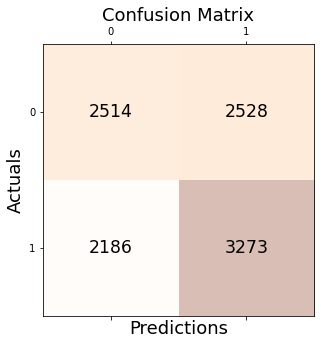

The confusion matrix shows us the number of :

* True positives : 2514 

* True negatives : 2528 

* False positives: 2186 

* False negatives: 3273 



In [39]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print('The confusion matrix shows us the number of :\n')
print('* True positives :', conf_matrix[0][0] ,'\n')
print('* True negatives :', conf_matrix[0][1],'\n')
print('* False positives:', conf_matrix[1][0] ,'\n')
print('* False negatives:', conf_matrix[1][1] ,'\n')

## KNeighbors - Classification Report

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.53      0.50      0.52      5042
         1.0       0.56      0.60      0.58      5459

    accuracy                           0.55     10501
   macro avg       0.55      0.55      0.55     10501
weighted avg       0.55      0.55      0.55     10501



## Kneighbors - Cross Validation Accuracy Score

In [240]:
print("Accuracy score using cross validation:", 
      round((cross_val_score(KN, X_train, y_train, cv=3, scoring='accuracy').mean())*100, 2), '%\n')

Accuracy score using cross validation: 55.1 %



## KNeighbors - Learning Curve

In [241]:
N, train_score, val_score = learning_curve(KN, 
                                           X_train, 
                                           y_train, 
                                           train_sizes = np.linspace(0.1, 1.0, 10),
                                           cv=5)

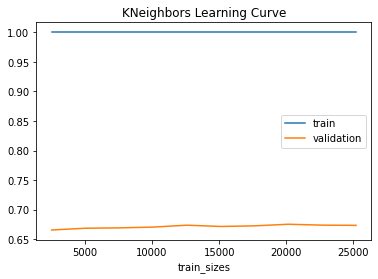

In [288]:
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.title('KNeighbors Learning Curve')
plt.show()

# Logistic regression

Our problem is a very binary one : will someone repay their credit or won't they ? 

This is why we use logistic regression as our machine learning model.

In [243]:
LR = LogisticRegression()

## LR - Model training

In [244]:
LR.fit(X_train, y_train)

LogisticRegression()

## LR - Model testing

In [245]:
y_pred = LR.predict(X_test)
print("Predictions:\n\n", y_pred, '\n')
print("Real values:\n\n", y_test)

Predictions:

 [1. 1. 0. ... 1. 0. 0.] 

Real values:

 37355    1.0
13162    0.0
9506     0.0
36447    1.0
43149    1.0
        ... 
30202    1.0
14590    0.0
8116     0.0
6233     0.0
1443     0.0
Name: TARGET, Length: 10501, dtype: float64


## LR - Model evaluation

### LR - Confusion Matrix

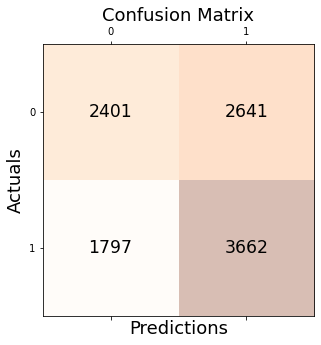

The confusion matrix shows us the number of :

* True positives : 2401 

* True negatives : 2641 

* False positives: 1797 

* False negatives: 3662 



In [246]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print('The confusion matrix shows us the number of :\n')
print('* True positives :', conf_matrix[0][0] ,'\n')
print('* True negatives :', conf_matrix[0][1],'\n')
print('* False positives:', conf_matrix[1][0] ,'\n')
print('* False negatives:', conf_matrix[1][1] ,'\n')

### LR - Classification Report

In [247]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.57      0.48      0.52      5042
         1.0       0.58      0.67      0.62      5459

    accuracy                           0.58     10501
   macro avg       0.58      0.57      0.57     10501
weighted avg       0.58      0.58      0.57     10501



### LR - Accuracy Score

In [248]:
print("Accuracy score:", round((accuracy_score(y_test, y_pred)*100), 3), '%\n')
print("Accuracy score using cross validation:", 
      round((cross_val_score(LR, X_train, y_train, cv=3, scoring='accuracy').mean())*100, 2), '%\n')

Accuracy score: 57.737 %

Accuracy score using cross validation: 57.66 %



Model accuracy is a machine learning model performance metric that is defined as the ratio of true positives and true negatives to all positive and negative observations.

The accuracy rate is great but it doesn’t tell us anything about the errors our machine learning models make on new data we haven’t seen before.

Mathematically, it represents the ratio of the sum of true positive and true negatives out of all the predictions.

### LR - Precision Score

In [249]:
print("Precision score:", round((precision_score(y_test, y_pred, average='macro')*100), 2), '%\n')

Precision score: 57.65 %



The precision score is a useful measure of the success of prediction when the classes are very imbalanced.

Mathematically, it represents the ratio of true positive to the sum of true positive and false positive.

### LR - Recall Score

In [250]:
print("Recall score:", round((metrics.recall_score(y_test, y_pred)*100), 2), '%\n')

Recall score: 67.08 %



Model recall score represents the model’s ability to correctly predict the positives out of actual positives. This is unlike precision which measures how many predictions made by models are actually positive out of all positive predictions made.

Recall score is a useful measure of success of prediction when the classes are very imbalanced. 

Mathematically, it represents the ratio of true positive to the sum of true positive and false negative.

### LR - F1 Score

In [286]:
print("F1 Score:", round((metrics.f1_score(y_test, y_pred)*100), 2), '%\n')

F1 Score: 69.27 %



F1-score is harmonic mean of precision and recall score and is used as a metrics in the scenarios where choosing either of precision or recall score can result in compromise in terms of model giving high false positives and false negatives respectively.

### LR - ROC Curve

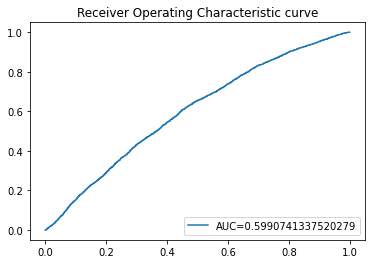

In [252]:
prediction_prob = LR.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  prediction_prob)
auc = metrics.roc_auc_score(y_test, prediction_prob)

#create ROC curve
plt.title("Receiver Operating Characteristic curve")
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()

This curve displays the percentage of true positives predicted by the model as the prediction probability cutoff is lowered from 1 to 0.

The higher the AUC (area under the curve), the more accurately our model is able to predict outcomes.

## LR - Learning Curve

In [253]:
N, train_score, val_score = learning_curve(LR, 
                                           X_train, 
                                           y_train,
                                           train_sizes = np.linspace(0.1, 1.0, 10),
                                           cv=5)

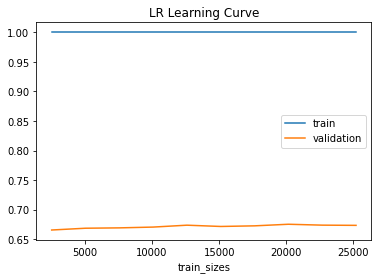

In [287]:
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.title('LR Learning Curve')
plt.show()

## Using our LR model on application test

In [255]:
app_test_LR = app_test.copy()
# app_test_LR['TARGET'] = 0

Application test doesn't have a TARGET column. 

That's why after the prediction, we can not see if our model finds the right value.

In [256]:
y_pred_test = LR.predict(app_test_LR)
app_test_LR['TARGET'] = y_pred_test.astype(int)
print(app_test_LR['TARGET'])

0        0
1        1
2        1
3        0
4        0
        ..
48739    0
48740    1
48741    1
48742    0
48743    1
Name: TARGET, Length: 39470, dtype: int32


# Decision Tree

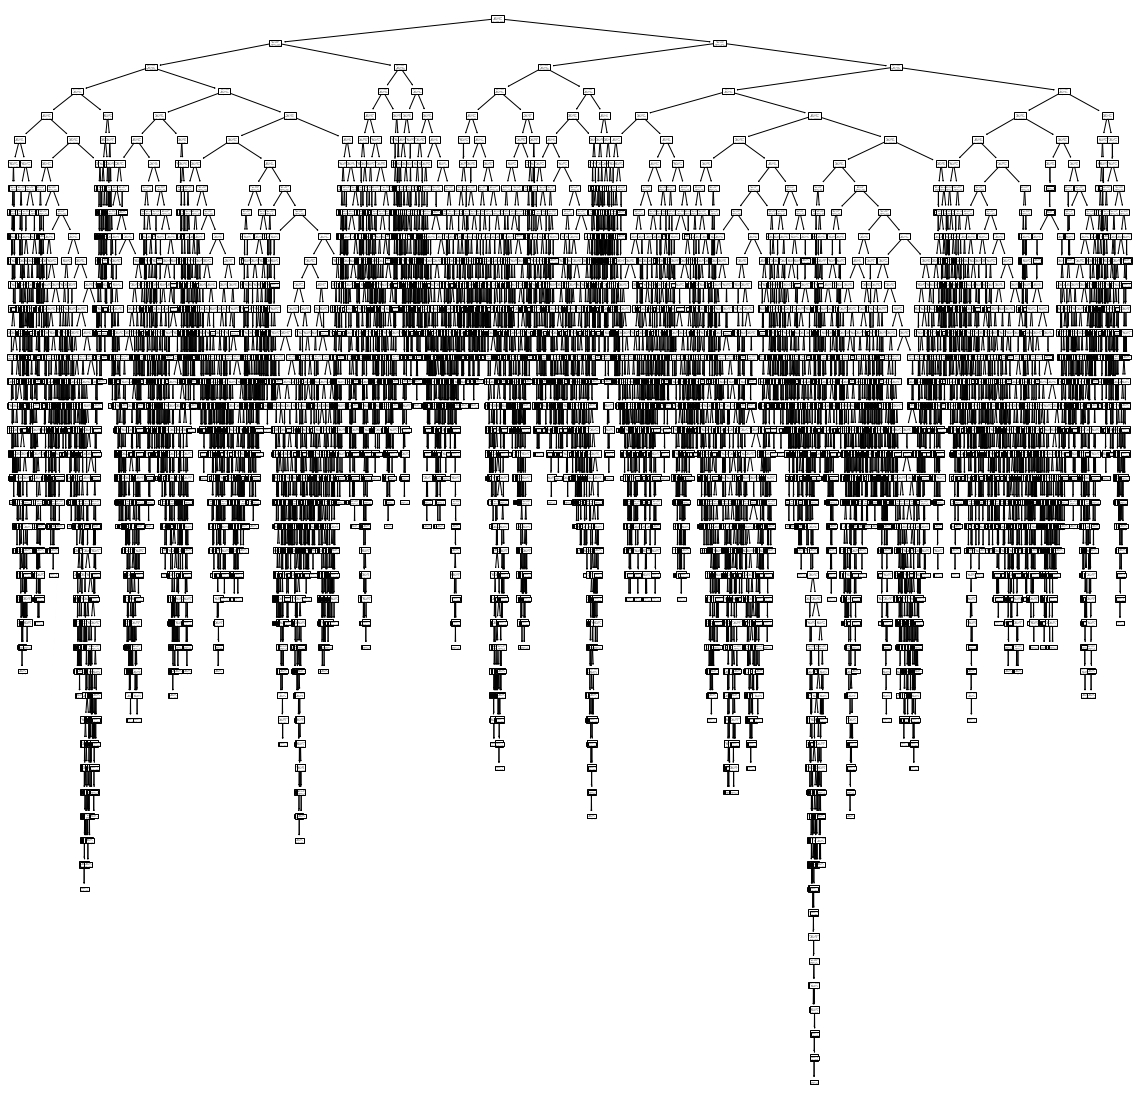

In [257]:
DT = DecisionTreeClassifier(criterion='gini')
DT.fit(X_train, y_train)
plt.figure(figsize=(20,20))
tree.plot_tree(DT)
plt.show()

## DT - Model testing

In [258]:
y_pred = DT.predict(X_test)
print("Predictions:\n\n", y_pred, '\n')
print("Real values:\n\n", y_test)

Predictions:

 [1. 1. 0. ... 0. 0. 0.] 

Real values:

 37355    1.0
13162    0.0
9506     0.0
36447    1.0
43149    1.0
        ... 
30202    1.0
14590    0.0
8116     0.0
6233     0.0
1443     0.0
Name: TARGET, Length: 10501, dtype: float64


## DT - Model evaluation

### DT - Confusion Matrix

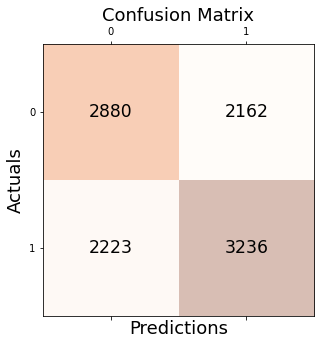

The confusion matrix shows us the number of :

* True positives : 2880 

* True negatives : 2162 

* False positives: 2223 

* False negatives: 3236 



In [259]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print('The confusion matrix shows us the number of :\n')
print('* True positives :', conf_matrix[0][0] ,'\n')
print('* True negatives :', conf_matrix[0][1],'\n')
print('* False positives:', conf_matrix[1][0] ,'\n')
print('* False negatives:', conf_matrix[1][1] ,'\n')

### DT - Classification report

In [260]:
print("Classification report:\n\n", classification_report(y_test, y_pred))

Classification report:

               precision    recall  f1-score   support

         0.0       0.56      0.57      0.57      5042
         1.0       0.60      0.59      0.60      5459

    accuracy                           0.58     10501
   macro avg       0.58      0.58      0.58     10501
weighted avg       0.58      0.58      0.58     10501



### DT - Accuracy Score

In [261]:
print("Accuracy score:", round((accuracy_score(y_test, y_pred)*100), 2), '%\n')
print("Accuracy score using cross validation:", 
      round((cross_val_score(DT, X_train, y_train, cv=3, scoring='accuracy').mean())*100, 2), '%\n')

Accuracy score: 58.24 %

Accuracy score using cross validation: 58.03 %



## DT - Learning Curve

In [262]:
N, train_score, val_score = learning_curve(DT, 
                                           X_train, 
                                           y_train,
                                           train_sizes = np.linspace(0.1, 1.0, 10),
                                           cv=5)

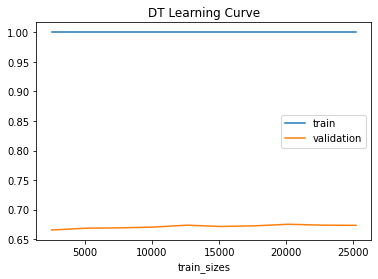

In [289]:
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.title('DT Learning Curve')
plt.show()

## Using our DT model on application test

In [264]:
app_test_DT = app_test.copy()
# app_test_DT['TARGET'] = 0

In [265]:
y_pred_test = DT.predict(app_test_DT)
app_test_DT['TARGET'] = y_pred_test.astype(int)
print(app_test_DT['TARGET'])

0        0
1        1
2        1
3        1
4        1
        ..
48739    0
48740    0
48741    0
48742    0
48743    1
Name: TARGET, Length: 39470, dtype: int32


# Random Forest

In [266]:
RF = RandomForestClassifier()

In [267]:
RF.fit(X_train, y_train)

RandomForestClassifier()

## RF - Model testing

In [268]:
y_pred = RF.predict(X_test)
print("Predictions:\n\n", y_pred, '\n')
print("Real values:\n\n", y_test)

Predictions:

 [1. 1. 0. ... 0. 0. 0.] 

Real values:

 37355    1.0
13162    0.0
9506     0.0
36447    1.0
43149    1.0
        ... 
30202    1.0
14590    0.0
8116     0.0
6233     0.0
1443     0.0
Name: TARGET, Length: 10501, dtype: float64


## RF - Model evaluation

### RF - Confusion Matrix

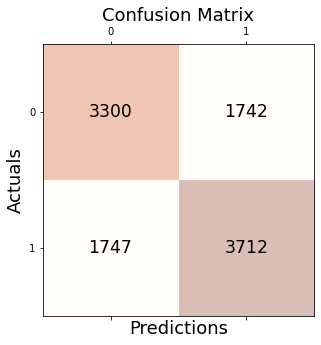

The confusion matrix shows us the number of :

* True positives : 3300 

* True negatives : 1742 

* False positives: 1747 

* False negatives: 3712 



In [269]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print('The confusion matrix shows us the number of :\n')
print('* True positives :', conf_matrix[0][0] ,'\n')
print('* True negatives :', conf_matrix[0][1],'\n')
print('* False positives:', conf_matrix[1][0] ,'\n')
print('* False negatives:', conf_matrix[1][1] ,'\n')

### RF - Classification Report

In [270]:
print("Classification report:", classification_report(y_test, y_pred))

Classification report:               precision    recall  f1-score   support

         0.0       0.65      0.65      0.65      5042
         1.0       0.68      0.68      0.68      5459

    accuracy                           0.67     10501
   macro avg       0.67      0.67      0.67     10501
weighted avg       0.67      0.67      0.67     10501



### RF -  Accuracy Score

In [271]:
print("Accuracy score:", round((accuracy_score(y_test, y_pred)*100), 2), '%\n')
print("Accuracy score using cross validation:", 
      round((cross_val_score(RF, X_train, y_train, cv=3, scoring='accuracy').mean())*100, 2), '%\n')

Accuracy score: 66.77 %

Accuracy score using cross validation: 67.4 %



## RF - Learning Curve

In [272]:
N, train_score, val_score = learning_curve(RF, 
                                           X_train, 
                                           y_train,
                                           train_sizes = np.linspace(0.1, 1.0, 10),
                                           cv=5)

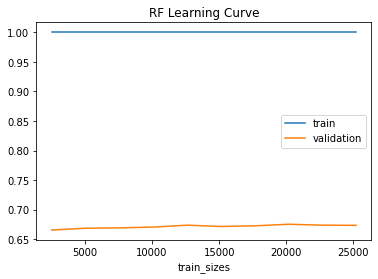

In [290]:
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.title('RF Learning Curve')
plt.show()

## Using our RF model on application test

In [274]:
app_test_RF = app_test.copy()
#app_test_RF['TARGET'] = 0

In [275]:
y_pred_test = RF.predict(app_test_RF)
app_test_RF['TARGET'] = y_pred_test.astype(int)
print(app_test_RF['TARGET'])

0        0
1        0
2        0
3        0
4        1
        ..
48739    0
48740    0
48741    0
48742    0
48743    1
Name: TARGET, Length: 39470, dtype: int32


# XGBoost

In [276]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

## XGBoost - Model training

In [277]:
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3}  # the number of classes that exist in this datset
num_round = 20  # the number of training iterations
XGBst = xgb.train(param, dtrain, num_round)

[15:13:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:13:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [278]:
"""
XGBst.dump_model('dump.raw.txt')
f = open('dump.raw.txt', 'r')
print(f.read())
"""

"\nXGBst.dump_model('dump.raw.txt')\nf = open('dump.raw.txt', 'r')\nprint(f.read())\n"

## XGBoost - Model Testing

In [279]:
probs_predictions = XGBst.predict(dtest)
y_pred = np.asarray([np.argmax(line) for line in probs_predictions])
print("Predictions:\n\n", y_pred, '\n')
print("Real values:\n\n", y_test)

Predictions:

 [1 1 0 ... 0 0 0] 

Real values:

 37355    1.0
13162    0.0
9506     0.0
36447    1.0
43149    1.0
        ... 
30202    1.0
14590    0.0
8116     0.0
6233     0.0
1443     0.0
Name: TARGET, Length: 10501, dtype: float64


## XGBoost - Model Evaluation

### XGBoost - Classification Report

In [280]:
print("Classification report:", classification_report(y_test, y_pred))

Classification report:               precision    recall  f1-score   support

         0.0       0.67      0.64      0.65      5042
         1.0       0.68      0.71      0.69      5459

    accuracy                           0.67     10501
   macro avg       0.67      0.67      0.67     10501
weighted avg       0.67      0.67      0.67     10501



### XGBoost - Confusion Matrix

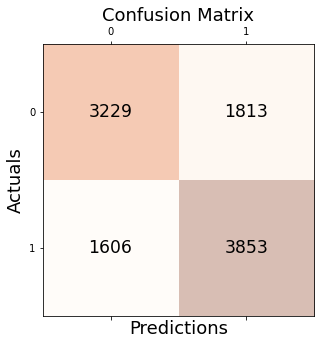

The confusion matrix shows us the number of :

* True positives : 3229 

* True negatives : 1813 

* False positives: 1606 

* False negatives: 3853 



In [281]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print('The confusion matrix shows us the number of :\n')
print('* True positives :', conf_matrix[0][0] ,'\n')
print('* True negatives :', conf_matrix[0][1],'\n')
print('* False positives:', conf_matrix[1][0] ,'\n')
print('* False negatives:', conf_matrix[1][1] ,'\n')

# Comparing models predictions on application test

In [282]:
LR_target = app_test_LR['TARGET'] 
DT_target = app_test_DT['TARGET']
RF_target = app_test_RF['TARGET']

one_dif = LR_target.compare(DT_target)
two_dif = LR_target.compare(RF_target)
three_dif = DT_target.compare(RF_target)

print('Difference between LR and DT on app_test:\nNumber of differences:', len(one_dif), '\n', one_dif)
print('Difference between LR and RF on app_test:\nNumber of differences:', len(two_dif), '\n', two_dif)
print('Difference between DT and RF on app_test:\nNumber of differences:', len(three_dif), '\n', three_dif)

if DT_target.equals(RF_target):
    print("Decision Tree and Random Forest found the same target values on application test")

if LR_target.equals(DT_target):
    if LR_target.equals(RF_target):
        print("All three models found the same target values on application test.")
else: 
    print("All three models did not find the same target values on application test.")

Difference between LR and DT on app_test:
Number of differences: 18166 
        self  other
3       0.0    1.0
4       0.0    1.0
5       0.0    1.0
6       1.0    0.0
8       1.0    0.0
...     ...    ...
48732   1.0    0.0
48734   1.0    0.0
48738   1.0    0.0
48740   1.0    0.0
48741   1.0    0.0

[18166 rows x 2 columns]
Difference between LR and RF on app_test:
Number of differences: 16460 
        self  other
1       1.0    0.0
2       1.0    0.0
4       0.0    1.0
6       1.0    0.0
8       1.0    0.0
...     ...    ...
48726   0.0    1.0
48729   1.0    0.0
48730   1.0    0.0
48740   1.0    0.0
48741   1.0    0.0

[16460 rows x 2 columns]
Difference between DT and RF on app_test:
Number of differences: 13158 
        self  other
1       1.0    0.0
2       1.0    0.0
3       1.0    0.0
5       1.0    0.0
16      1.0    0.0
...     ...    ...
48729   1.0    0.0
48730   1.0    0.0
48732   0.0    1.0
48734   0.0    1.0
48738   0.0    1.0

[13158 rows x 2 columns]
All three models di

# Conclusion

The data given was very unbalanced, we had to use undersampling to balance it to get accurate models.
As the bank, if the model predicts too many true positives, this is not an issue. The bank would not give the loan to someone who could have repaid it. This isn't so great for the clients.